In [4]:
# Import libraries

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_blobs
from sklearn.metrics import roc_auc_score
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
np.random.seed(24)

Over-Sampling methods can:
* Random Selection
* Random Generation
* Generate Observations harder to classify
So we increase the observations from the minority class but we might also amplify noise.

Under-Sampling methods can:
* Random Selection
* Remove noisy observations
* Remove easy to classify observations
We may loose important information from the majority class but we remove noisy observations.

So if we combine both over-sampling and under-sampling together, we can have more observations from the minority class but also remove noisy observations from the majority class.

If we combine both random over-sampling and random under-sampling, we might remove equally noisy observations or not noisy observations which leads to more observations that are hard to classify.

So the best combinaison is an over-sampling method that generate random observations from the minority class, like the SMOTE, and an under-sampling method that remove noisy observations (ENN, Tomek Links, Instance Hardness, NCR).

In [28]:
def load_data():
    
    df = pd.read_csv("./kdd2004.csv")
    df["target"] = df["target"].map({-1:0,1:1})
    
    return df

In [3]:
def make_class(sep):
    """Will create classes with different degrees of separateness."""

    X, y = make_classification(n_samples=1000,
                               n_features=2,
                               n_redundant=0,
                               n_classes=2,
                               n_clusters_per_class=1,
                               # The proportions of samples assigned to each class
                               weights=[0.99],
                               # How seperate the classes are
                               class_sep=sep,  
                               random_state=24,
                               )
    X = pd.DataFrame(X, columns=["varA", "varB"])

    y = pd.Series(y)

    return X, y

In [30]:
def run_rf(X_train,X_test,y_train,y_test):
    
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=200,max_depth=4)
    rf.fit(X_train,y_train)
    
    y_pred = rf.predict_proba(X_test)[:,1]
    
    print(f"ROC-AUC for the train set: {roc_auc_score(y_train,rf.predict_proba(X_train)[:,1])}")
    print(f"ROC-AUC for the test set: {roc_auc_score(y_test,y_pred)}")

In [18]:
X, y = make_class(sep=2)

smote = SMOTE(sampling_strategy='auto',
            random_state=24,
            k_neighbors=5,
            n_jobs=-1,
            )
X_smote, y_smote = smote.fit_resample(X, y)

In [19]:
ENN = EditedNearestNeighbours(sampling_strategy='auto',
                              n_neighbors=3,
                              kind_sel='all',
                              n_jobs=-1,
                              )
X_enn, y_enn = ENN.fit_resample(X, y)

In [20]:
smenn = SMOTEENN(sampling_strategy='auto',
         random_state=24,
         smote=smote,
         enn=ENN,
         n_jobs=-1,
         )
X_smoteenn, y_smoteenn = smenn.fit_resample(X, y)

In [21]:
tl = TomekLinks(sampling_strategy='auto', n_jobs=-1)
smtomek = SMOTETomek(sampling_strategy='auto',
    random_state=24,
    smote=smote,
    tomek=tl,
    n_jobs=-1,
)
X_smtomek, y_smtomek = smtomek.fit_resample(X, y)

In [22]:
X_smoteenn.shape, y_smoteenn.shape,X_smtomek.shape, y_smtomek.shape

((1859, 2), (1859,), (1940, 2), (1940,))

In [23]:
y.value_counts(),y_smoteenn.value_counts(),y_smtomek.value_counts()

(0    987
 1     13
 dtype: int64,
 0    987
 1    872
 dtype: int64,
 0    987
 1    953
 dtype: int64)

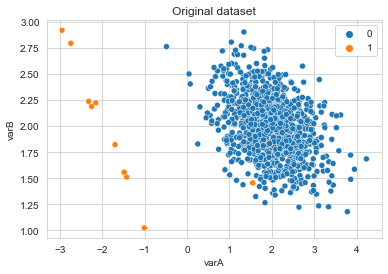

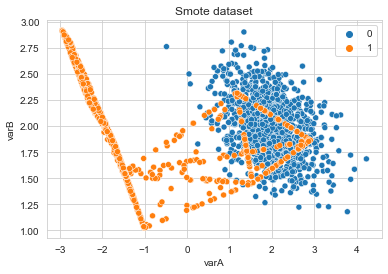

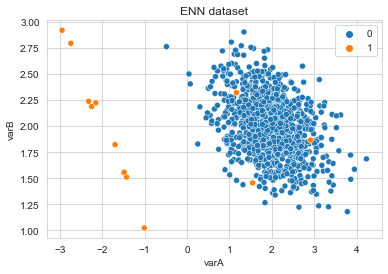

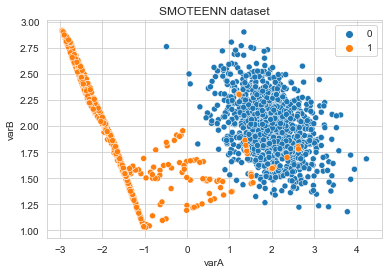

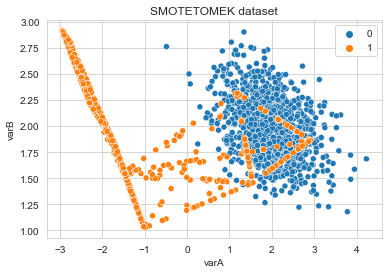

In [25]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

sns.scatterplot(data=X_smote, x="varA", y="varB", hue=y_smote)

plt.title(f"Smote dataset")
plt.show()

sns.scatterplot(data=X_enn, x="varA", y="varB", hue=y_enn)

plt.title(f"ENN dataset")
plt.show()

sns.scatterplot(data=X_smoteenn, x="varA", y="varB", hue=y_smoteenn)

plt.title(f"SMOTEENN dataset")
plt.show()

sns.scatterplot(data=X_smtomek, x="varA", y="varB", hue=y_smtomek)

plt.title(f"SMOTETOMEK dataset")
plt.show()

In [29]:
df = load_data()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [33]:
X_resampled_smote,y_resampled_smote = smote.fit_resample(df.drop(labels=["target"],axis=1),df["target"])
X_resampled_enn,y_resampled_enn = ENN.fit_resample(df.drop(labels=["target"],axis=1),df["target"])
X_resampled_smenn,y_resampled_smenn = smenn.fit_resample(df.drop(labels=["target"],axis=1),df["target"])
X_resampled_smtomek,y_resampled_smtomek = smtomek.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [34]:
X_train_resampled_smote, X_test_resampled_smote, y_train_resampled_smote, y_test_resampled_smote = train_test_split(X_resampled_smote,y_resampled_smote,test_size=0.33, random_state=24)
X_train_resampled_enn, X_test_resampled_enn, y_train_resampled_enn, y_test_resampled_enn = train_test_split(X_resampled_enn,y_resampled_enn,test_size=0.33, random_state=24)
X_train_resampled_smenn, X_test_resampled_smenn, y_train_resampled_smenn, y_test_resampled_smenn = train_test_split(X_resampled_smenn,y_resampled_smenn,test_size=0.33, random_state=24)
X_train_resampled_smtomek, X_test_resampled_smtomek, y_train_resampled_smtomek, y_test_resampled_smtomek = train_test_split(X_resampled_smtomek,y_resampled_smtomek,test_size=0.33, random_state=24)

In [35]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9761414267359368
ROC-AUC for the test set: 0.9640441514681941


In [36]:
run_rf(X_train_resampled_smote, X_test_resampled_smote, y_train_resampled_smote, y_test_resampled_smote)

ROC-AUC for the train set: 0.9917121736977554
ROC-AUC for the test set: 0.99152261319249


In [38]:
run_rf(X_train_resampled_enn, X_test_resampled_enn, y_train_resampled_enn, y_test_resampled_enn)

ROC-AUC for the train set: 0.9756102736264138
ROC-AUC for the test set: 0.9712563964914627


In [39]:
run_rf(X_train_resampled_smenn, X_test_resampled_smenn, y_train_resampled_smenn, y_test_resampled_smenn)

ROC-AUC for the train set: 0.9922248533429294
ROC-AUC for the test set: 0.9915762560329717


In [40]:
run_rf(X_train_resampled_smtomek, X_test_resampled_smtomek, y_train_resampled_smtomek, y_test_resampled_smtomek)

ROC-AUC for the train set: 0.9922947402690079
ROC-AUC for the test set: 0.9921368878694781


In [45]:
# Importing the needed libraries
from collections import Counter

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

from imblearn.datasets import fetch_datasets

from imblearn.over_sampling import (SMOTENC,
                                   ADASYN,
                                   BorderlineSMOTE,
                                   SVMSMOTE)

In [46]:
oversampler_dict = {
    "smote": SMOTE(sampling_strategy='auto',
                   random_state=24,
                   k_neighbors=5,
                   n_jobs=-1,
                   ),
    "smotenc": SMOTENC(categorical_features=[2, 3],
                       sampling_strategy='auto',
                       random_state=24,
                       k_neighbors=5,
                       n_jobs=-1,
                       ),
    "ADASYN": ADASYN(sampling_strategy='auto',
                     random_state=24,
                     n_neighbors=5,
                     n_jobs=-1),
    "BorderlineSMOTE-1": BorderlineSMOTE(sampling_strategy='auto',
                                         random_state=24,
                                         k_neighbors=5,
                                         n_jobs=-1,
                                         m_neighbors=10,
                                         kind='borderline-1',
                                         ),
    "BorderlineSMOTE-2": BorderlineSMOTE(sampling_strategy='auto',
                                         random_state=24,
                                         k_neighbors=5,
                                         n_jobs=-1,
                                         m_neighbors=10,
                                         kind='borderline-2',
                                         ),
    "SVMSMOTE": SVMSMOTE(sampling_strategy='auto',
                         random_state=24,
                         k_neighbors=5,
                         n_jobs=-1,
                         m_neighbors=10,
                         svm_estimator=SVC(kernel="linear"),
                         out_step=0.5,
                         ),
    "SMOTE-TOMEK": SMOTETomek(sampling_strategy='auto',
                              random_state=24,
                              smote=smote,
                              tomek=tl,
                              n_jobs=-1,
                              ),
    "SMOTE-ENN": SMOTEENN(sampling_strategy='auto',
                          random_state=24,
                          smote=smote,
                          enn=ENN,
                          n_jobs=-1,
                          )
}

In [47]:
datasets = [
    "car_eval_34",
    "ecoli",
    "car_eval_4",
    "wine_quality",
    "coil_2000"
]

In [48]:
for dataset in datasets:
    print(f"Dataset name: {dataset}")
    print(Counter(fetch_datasets()[dataset].target))
    print("\n")

Dataset name: car_eval_34
Counter({-1: 1594, 1: 134})


Dataset name: ecoli
Counter({-1: 301, 1: 35})


Dataset name: car_eval_4
Counter({-1: 1663, 1: 65})


Dataset name: wine_quality
Counter({-1: 4715, 1: 183})


Dataset name: coil_2000
Counter({-1: 9236, 1: 586})




In [49]:
def run_rf(X_train,X_test,y_train,y_test):
    
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=100,max_depth=3)
    rf.fit(X_train,y_train)
    
    y_pred = rf.predict_proba(X_test)[:,1]
    
    print(f"ROC-AUC for the train set: {roc_auc_score(y_train,rf.predict_proba(X_train)[:,1])}")
    print(f"ROC-AUC for the test set: {roc_auc_score(y_test,y_pred)}")
    
    return roc_auc_score(y_test,y_pred)

In [50]:
results_dic = {}
shape_dataset = {}

for dataset in datasets:

    print(dataset)
    print("\n")
    print("Results for the original dataset")
    
    # Dict to store the results
    results_dic[dataset] = {}
    shape_dataset[dataset] = {}

    # Load the dataset
    data = fetch_datasets()[dataset]

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        data.data, data.target, test_size=0.33, random_state=24)

    # Scaler because of the KNN used by the undersampling methods
    scaler = MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Getting the performance for the original dataset
    roc = run_rf(X_train, X_test, y_train, y_test)
    
    results_dic[dataset]["full_data"] = roc
    shape_dataset[dataset]["full_data"] = len(X_train)

    # Trying all the undersampling methods
    for oversampler in oversampler_dict.keys():
        
        print(oversampler)
        
        # Fit transform with the undersampling method
        X_resampled, y_resampled = oversampler_dict[oversampler].fit_resample(
            X_train, y_train)

        # Getting the performance
        roc = run_rf(X_resampled, X_test, y_resampled, y_test)

        results_dic[dataset][oversampler] = roc
        shape_dataset[dataset][oversampler] = len(X_resampled)
        print("\n")

    print("\n")

car_eval_34


Results for the original dataset
ROC-AUC for the train set: 0.9822366388631448
ROC-AUC for the test set: 0.9878640776699029
smote
ROC-AUC for the train set: 0.9977590550410096
ROC-AUC for the test set: 0.9970873786407768


smotenc
ROC-AUC for the train set: 0.9952234975404577
ROC-AUC for the test set: 0.9937933425797504


ADASYN
ROC-AUC for the train set: 0.9959549558963853
ROC-AUC for the test set: 0.9944174757281554


BorderlineSMOTE-1
ROC-AUC for the train set: 0.9957989797644989
ROC-AUC for the test set: 0.9938973647711511


BorderlineSMOTE-2
ROC-AUC for the train set: 0.994642861744261
ROC-AUC for the test set: 0.9929611650485437


SVMSMOTE
ROC-AUC for the train set: 0.9915077720162749
ROC-AUC for the test set: 0.9914181692094314


SMOTE-TOMEK
ROC-AUC for the train set: 0.9956967672500797
ROC-AUC for the test set: 0.994140083217753


SMOTE-ENN
ROC-AUC for the train set: 0.997065470121736
ROC-AUC for the test set: 0.9967753120665742




ecoli


Results for the origina

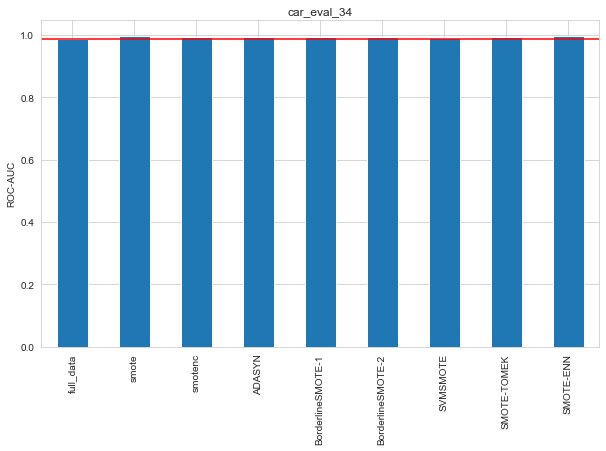

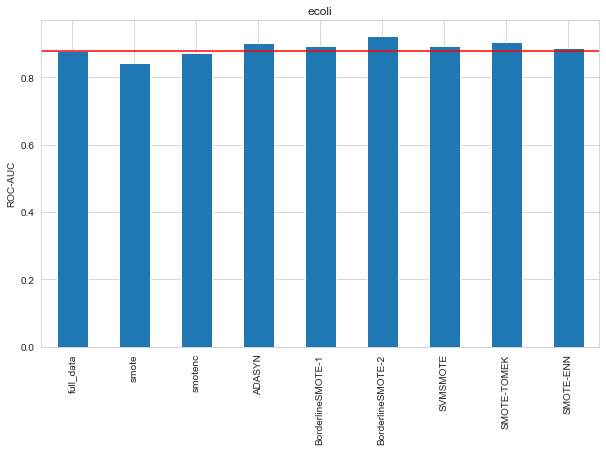

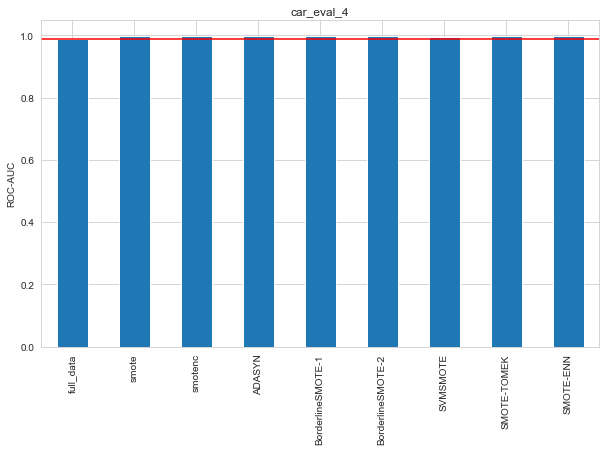

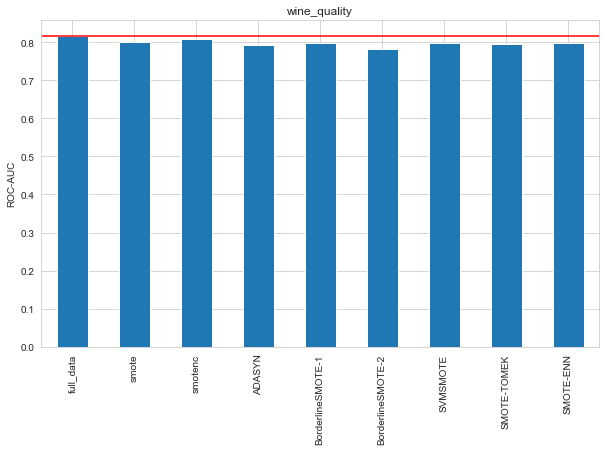

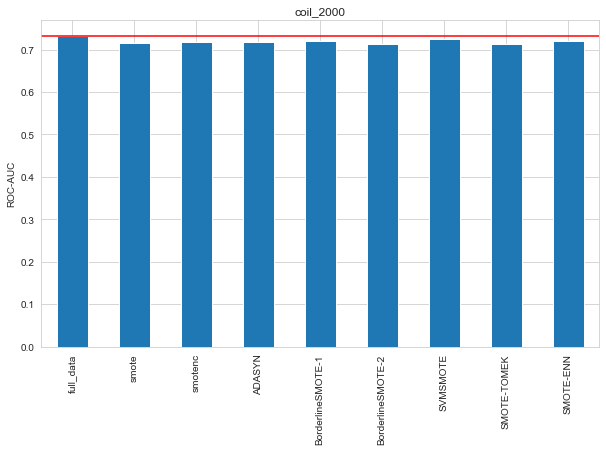

In [51]:
for dataset in datasets:
    plt.figure(figsize=(10,6))
    pd.Series(results_dic[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel("ROC-AUC")
    plt.axhline(results_dic[dataset]["full_data"],color="r")
    plt.show()

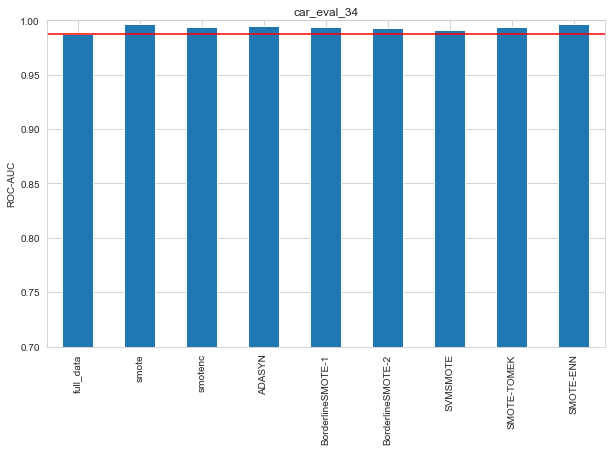

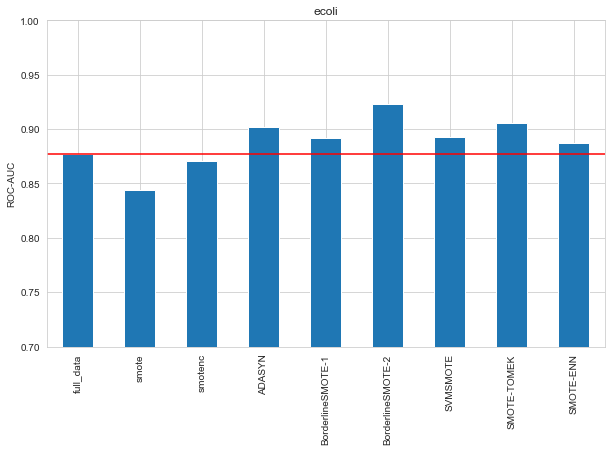

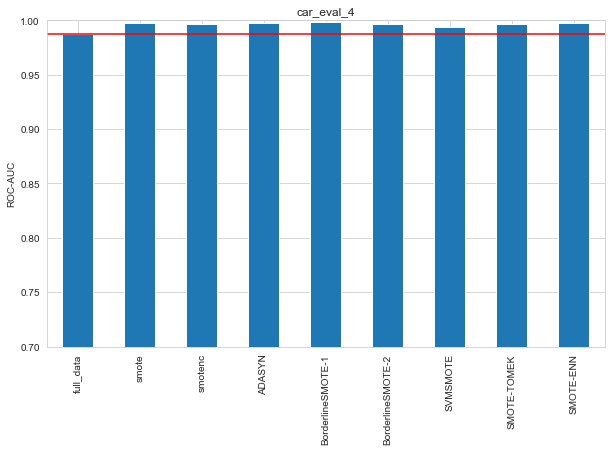

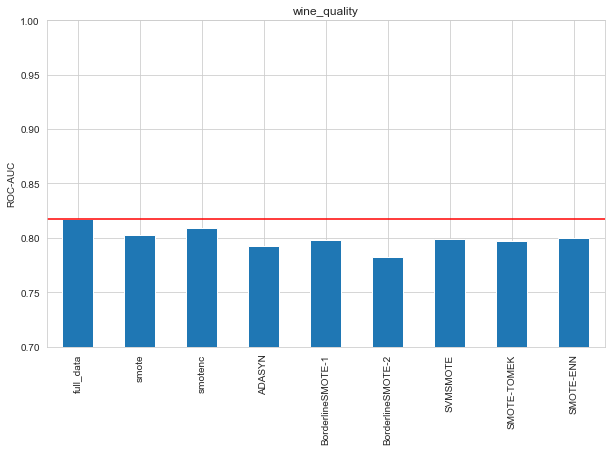

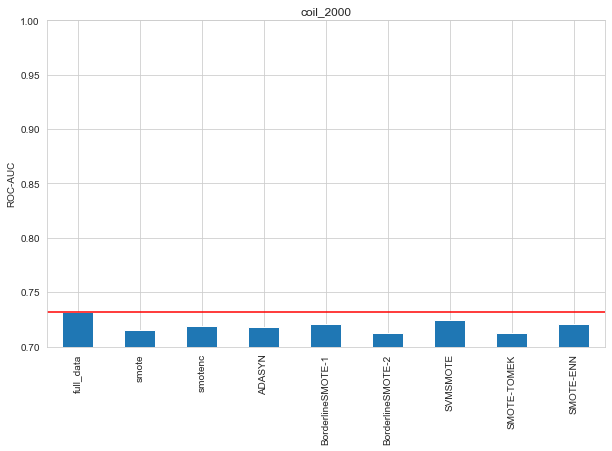

In [52]:
for dataset in datasets:
    plt.figure(figsize=(10,6))
    pd.Series(results_dic[dataset]).plot.bar()
    plt.ylim(0.7,1)
    plt.title(dataset)
    plt.ylabel("ROC-AUC")
    plt.axhline(results_dic[dataset]["full_data"],color="r")
    plt.show()